# Testing the MLE Fitting Functions

The Hawkes module implements the multivariate Hawkes marked point process. We assume an exponential decay function is used to improve the numerical computation of the intensity function [Liniger, 2012].

Generating artificial points to be used as data for fit (see simulation notebook):

In [6]:
import hawkes
import markDistributions as md
import numpy as np
import scipy.optimize as op
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import rcParams

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
rcParams['figure.figsize'] = 16, 5

d=2
numPoints=10200

eta=[0.021,0.029]
Q=[0.61,0.16,0.6,0.06]
alpha=[0.005]*d
mu=[3.6,4.2]
rho=[5.6,7.2]
alph=[0.47,1.1]
beta=[0.22,0.0]

mdParam1=[alph[0],beta[0]]
mdParam2=[alph[1],beta[1]]

sparam = []
sparam.extend(eta)
sparam.extend(Q)
sparam.extend(alpha)
sparam.extend(mdParam1)
sparam.extend(mdParam2)

markparam = [[mu[0],rho[0]],[mu[1],rho[1]]]

sim = hawkes.Hawkes(d=d)
sim.setParam(sparam)
sim.setMarkDistParam(markparam)

t,j,x = sim.simulate(numPoints)[0]

Setup a seperate Hawkes marked point process and set the mark distribution parameters:

In [7]:
h = hawkes.Hawkes(d=d)
h.setMarkDistParam(markparam)

Fit the new Hawkes process to the simulated data using L-BFGS-B to get good initialization:

In [8]:
result = h.MLE(t,j,x,method='L-BFGS-B')

arr = result["x"]

print("""eta:
        {0} - estimated
        {1} - true\n""".format(arr[:2],np.asarray(eta)))
print("""Q:
        {0} - estimated
        {1} - true\n""".format(arr[2:6],np.asarray(Q)))
print("""alpha:
        {0} - estimated
        {1} - true\n""".format(arr[6:8],np.asarray(alpha)))
print("""alph:
        {0} - estimated
        {1} - true\n""".format(arr[8:10],np.asarray(alph)))
print("""beta:
        {0} - estimated
        {1} - true\n""".format(arr[10:12],np.asarray(beta)))

print("""Spr(Q) of estimated model: {0}""".format(h.ibParam.getSpectralRadius()))

eta:
        [ 0.023  0.026] - estimated
        [ 0.021  0.029] - true

Q:
        [ 0.685  0.089  0.641  0.075] - estimated
        [ 0.61  0.16  0.6   0.06] - true

alpha:
        [ 0.005  0.005] - estimated
        [ 0.005  0.005] - true

alph:
        [ 17.203   0.196] - estimated
        [ 0.47  1.1 ] - true

beta:
        [ 0.231  2.027] - estimated
        [ 0.22  0.  ] - true

Spr(Q) of estimated model: 0.767807230125


Restarting optimization using SLSQP:

In [9]:
result = h.MLE(t,j,x,method='SLSQP',x0=arr)

arr = result["x"]

print("""eta:
        {0} - estimated
        {1} - true\n""".format(arr[:2],np.asarray(eta)))
print("""Q:
        {0} - estimated
        {1} - true\n""".format(arr[2:6],np.asarray(Q)))
print("""alpha:
        {0} - estimated
        {1} - true\n""".format(arr[6:8],np.asarray(alpha)))
print("""alph:
        {0} - estimated
        {1} - true\n""".format(arr[8:10],np.asarray(alph)))
print("""beta:
        {0} - estimated
        {1} - true\n""".format(arr[10:12],np.asarray(beta)))

print("""Spr(Q) of estimated model: {0}""".format(h.ibParam.getSpectralRadius()))

eta:
        [ 0.024  0.028] - estimated
        [ 0.021  0.029] - true

Q:
        [ 0.678  0.079  0.618  0.076] - estimated
        [ 0.61  0.16  0.6   0.06] - true

alpha:
        [ 0.004  0.005] - estimated
        [ 0.005  0.005] - true

alph:
        [ 14.248   9.026] - estimated
        [ 0.47  1.1 ] - true

beta:
        [ 0.975  3.949] - estimated
        [ 0.22  0.  ] - true

Spr(Q) of estimated model: 0.75067145763


Simulating the new Hawkes model using estimated parameters:

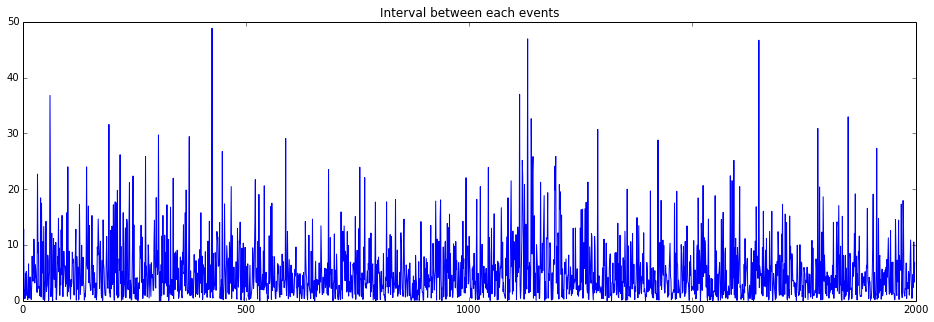

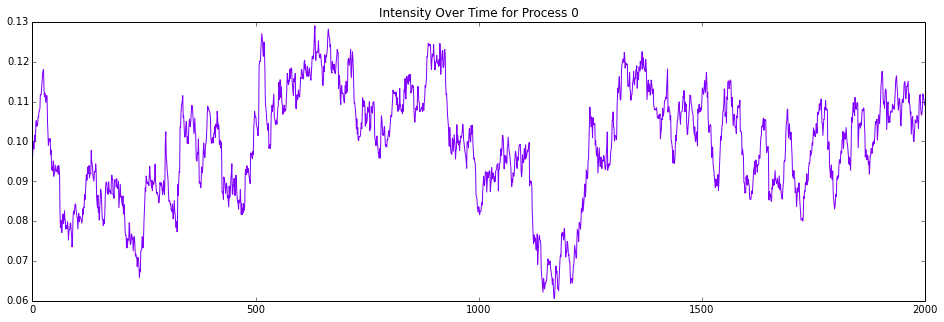

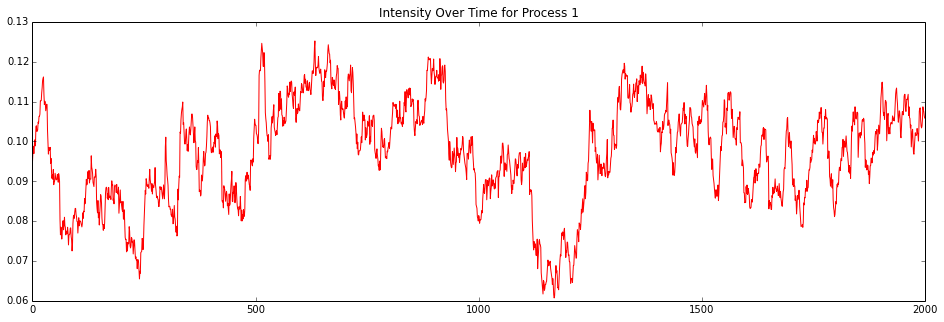

In [13]:
simulatedPoints, simulatedIntensities = h.simulate(2200)

intervals = simulatedPoints[0][1:] - simulatedPoints[0][:-1]

plt.title('Interval between each events')
plt.plot(np.arange(len(intervals)),intervals)
plt.show()

colors = cm.rainbow(np.linspace(0, 1, d))
for i,c in zip(xrange(d), colors):
    plt.title('Intensity Over Time for Process ' + str(i))
    plt.plot(simulatedIntensities[:,i], color=c)
    plt.show()